In [204]:
from dragonFunctions import *
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import plotly.express as px
import pylab
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency
from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
from sklearn.calibration import calibration_curve
import seaborn as sns

sns.set_theme()

base_directory = Path('..') / 'Data'

base_directory.mkdir(parents=True, exist_ok=True)

# Data Loading

In [205]:
patient_df = pd.read_csv('/Users/josh/Desktop/Macbook Working Files/Git Repos/650-DRAGON-SLAYERS/FILES/Data/patient_df.csv')

# Data Preprocessing

## Keep Only First Admission

In [206]:
patient_df = patient_df.drop_duplicates(subset='SUBJECT_ID', keep='first')

## Define 30-Day Mortality Boolean

In [207]:
patient_df['DOD'] = pd.to_datetime(patient_df['DOD'])
patient_df['ADMITTIME'] = pd.to_datetime(patient_df['ADMITTIME'])

# define 30-days mortality column 
patient_df['DIFF_DAYS'] = (patient_df['DOD'] - patient_df['ADMITTIME']).dt.days
patient_df['MORTALITY'] = patient_df['DIFF_DAYS'].apply(lambda x: 0 if x>30 else 1)

In [208]:
patient_df['MORTALITY'].value_counts()

1    3281
0    1274
Name: MORTALITY, dtype: int64

## Group Ethnicities

In [209]:
def consolidate_ethnicity(ethnicity):
    ethnicity = ethnicity.upper()  # Convert to uppercase for consistency
    
    # Grouping logic
    if 'WHITE' in ethnicity:
        return 'WHITE'
    elif 'BLACK' in ethnicity or 'AFRICAN AMERICAN' in ethnicity:
        return 'BLACK OR AFRICAN AMERICAN'
    elif 'ASIAN' in ethnicity:
        return 'ASIAN'
    elif 'HISPANIC' in ethnicity or 'LATINO' in ethnicity:
        return 'HISPANIC OR LATINO'
    elif 'AMERICAN INDIAN' in ethnicity or 'ALASKA NATIVE' in ethnicity:
        return 'AMERICAN INDIAN OR ALASKA NATIVE'
    elif 'NATIVE HAWAIIAN' in ethnicity or 'PACIFIC ISLANDER' in ethnicity:
        return 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER'
    elif 'MIDDLE EASTERN' in ethnicity:
        return 'MIDDLE EASTERN'
    elif ('UNKNOWN' in ethnicity or 'NOT SPECIFIED' in ethnicity or
          'DECLINED TO ANSWER' in ethnicity or 'UNABLE TO OBTAIN' in ethnicity):
        return 'UNKNOWN/NOT SPECIFIED/DECLINED'
    else:
        return 'OTHER'
    

# Apply the consolidation to create a new column
patient_df['ETHNICITY_CONSOLIDATED'] = patient_df['ETHNICITY'].apply(consolidate_ethnicity)

print(patient_df['ETHNICITY_CONSOLIDATED'].value_counts())

WHITE                                        3360
BLACK OR AFRICAN AMERICAN                     436
UNKNOWN/NOT SPECIFIED/DECLINED                340
ASIAN                                         148
HISPANIC OR LATINO                            144
OTHER                                         117
AMERICAN INDIAN OR ALASKA NATIVE                4
MIDDLE EASTERN                                  4
NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER       2
Name: ETHNICITY_CONSOLIDATED, dtype: int64


## Drop Extraneous Columns

Unnecessary patient data and identifiers will be dropped from the `patient_df`

In [210]:
columns_to_drop = ['Unnamed: 0', 'SUBJECT_ID', 'DOB', 'DOD','HOSPITAL_EXPIRE_FLAG', 'HADM_ID', 'ADMITTIME', 'DIFF_DAYS', 'DISCHTIME', 'ETHNICITY','TEMP_MEAN_C', 'CHLORIDE_MAX_VAL', 'CREATININE_MAX_VAL', 'LACTATE_MAX_VAL', 'PLATELET_MAX_VAL','POTASSIUM_MAX_VAL']
existing_columns_to_drop = [col for col in columns_to_drop if col in patient_df.columns]

# Drop the columns
patient_df = patient_df.drop(columns=existing_columns_to_drop)

patient_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4555 entries, 0 to 5175
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   GENDER                  4555 non-null   object 
 1   ADMISSION_TYPE          4555 non-null   object 
 2   AGE_AT_ADMISSION        4555 non-null   int64  
 3   LOS                     4555 non-null   int64  
 4   LOS_ICU_MEAN            4554 non-null   float64
 5   WEIGHT_MEAN             4323 non-null   float64
 6   HEARTRATE_MEAN          4550 non-null   float64
 7   SBP_MEAN                4551 non-null   float64
 8   DBP_MEAN                4551 non-null   float64
 9   MAP_MEAN                4551 non-null   float64
 10  RR_MEAN                 4551 non-null   float64
 11  TEMP_MIN_C              4543 non-null   float64
 12  TEMP_MAX_C              4543 non-null   float64
 13  OXYGEN_SAT_MEAN         4547 non-null   float64
 14  DIABETES                4555 non-null   

## Encoding Categorical Features

In [211]:
# Identify categorical columns
categorical_cols = patient_df.select_dtypes(include=['object', 'category']).columns.tolist()

df = pd.get_dummies(patient_df, columns=categorical_cols, drop_first=True)

## Handle `null` Values

In [212]:
null_counts = df.isnull().sum()

null_counts_df = null_counts.reset_index()
null_counts_df.columns = ['Column Name', 'Null Count']

total_rows = len(df)
null_counts = df.isnull().sum()
null_percent = (null_counts / total_rows) * 100

null_summary = pd.DataFrame({
    'Null Count': null_counts,
    'Null Percentage (%)': null_percent
})

null_summary

,Null Count,Null Percentage (%)
AGE_AT_ADMISSION,0,0.000000
LOS,0,0.000000
LOS_ICU_MEAN,1,0.021954
WEIGHT_MEAN,232,5.093304
HEARTRATE_MEAN,5,0.109769
SBP_MEAN,4,0.087816
DBP_MEAN,4,0.087816
MAP_MEAN,4,0.087816
RR_MEAN,4,0.087816
TEMP_MIN_C,12,0.263447


In [213]:
numerical_cols = df.select_dtypes(include=['number']).columns
mean_values = df[numerical_cols].mean()

df[numerical_cols] = df[numerical_cols].fillna(mean_values)
null_counts = df[numerical_cols].isnull().sum()

## Outlier Handling

We handle outliers using two functions: 

1. `preprocess_outliers(df, threshold=3)`
2. `compare_summary_stats(summary_before, summary_after)`



```python
def preprocess_outliers(df, threshold=3):
    """
    Detects and caps outliers in non-binary numerical columns of the DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - threshold (float): Number of standard deviations to define outliers.
    
    Returns:
    - df_capped (pd.DataFrame): DataFrame with outliers capped.
    - summary_before (pd.DataFrame): Summary statistics before capping.
    - summary_after (pd.DataFrame): Summary statistics after capping.
    - capped_summary (pd.DataFrame): Count of capped values per column.
    """
```

```python
def compare_summary_stats(summary_before, summary_after):
    """
    Compares summary statistics before and after outlier handling.
    
    Parameters:
    - summary_before (pd.DataFrame): Summary statistics before handling outliers.
    - summary_after (pd.DataFrame): Summary statistics after handling outliers.
    
    Returns:
    - comparison_table (pd.DataFrame): Table showing before, after, and changes.
    """
```

In [214]:
def save_dataframe(df, filename, base_dir):
    file_path = base_dir / filename
    df.to_csv(file_path, index=False)
    print(f"{filename} saved successfully at: {file_path.resolve()}")

df_capped, summary_before, summary_after, capped_summary, binary_numerical_cols = preprocess_outliers(df, threshold=2)

comparison_table = compare_summary_stats(summary_before, summary_after, capped_summary)

save_dataframe(comparison_table, 'Outlier_Report.csv', base_directory)
save_dataframe(df_capped, 'patient_df_capped.csv', base_directory)

Outlier_Report.csv saved successfully at: /Users/josh/Desktop/Macbook Working Files/Git Repos/650-DRAGON-SLAYERS/FILES/Data/Outlier_Report.csv
patient_df_capped.csv saved successfully at: /Users/josh/Desktop/Macbook Working Files/Git Repos/650-DRAGON-SLAYERS/FILES/Data/patient_df_capped.csv


# EDA

We get the mean and p-values of the numberical features using the following functions: `mean_confidence_interval` and `get_stats`

```python

def mean_confidence_interval(data, confidence=0.95):
    """
    Calculate the mean and confidence interval for a list of numbers.
    """

def get_stats(df, group_col='MORTALITY', confidence=0.95):
    """
    Analyze numerical features in the dataframe, aggregating by the specified group column.
    
    Parameters:
    - df: pandas DataFrame
    - group_col: column name to group by (binary: 0 or 1)
    - confidence: confidence level for intervals
    
    Returns:
    - result_df: pandas DataFrame with mean (CI) for each group and p-value
    """
```

In [215]:
eda_df = get_stats(df_capped)
eda_df.sort_values('p-value')

save_dataframe(eda_df, 'Feature_Means_Report.csv', base_directory)

Feature_Means_Report.csv saved successfully at: /Users/josh/Desktop/Macbook Working Files/Git Repos/650-DRAGON-SLAYERS/FILES/Data/Feature_Means_Report.csv


# Models

### Train Test Split and Scaling

In [216]:
# Define features and target
X = df_capped.drop(['MORTALITY'], axis=1)
y = df_capped['MORTALITY']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Identify numerical features for scaling
# Assuming all features are numerical; if not, adjust accordingly
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

## Logistic Regression

Cross-Validation Accuracy Scores: [0.75445816 0.73113855 0.74211248 0.73251029 0.71428571]
Average Cross-Validation Accuracy: 0.7349


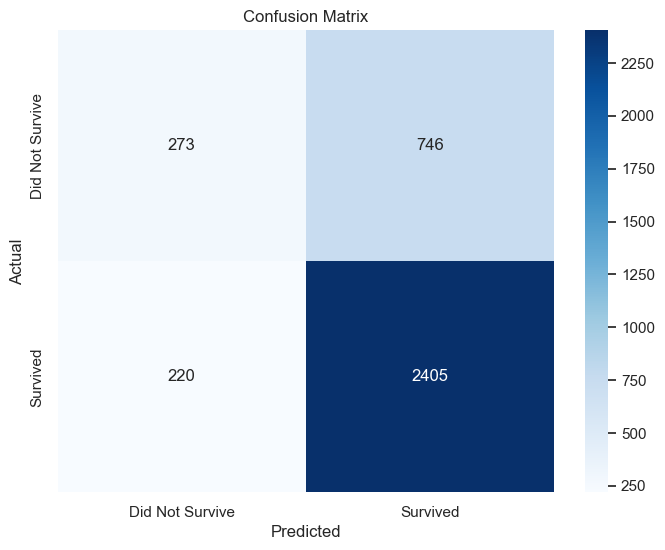

LogisticRegressionCoefficients.csv saved successfully at: /Users/josh/Desktop/Macbook Working Files/Git Repos/650-DRAGON-SLAYERS/FILES/Data/LogisticRegressionCoefficients.csv


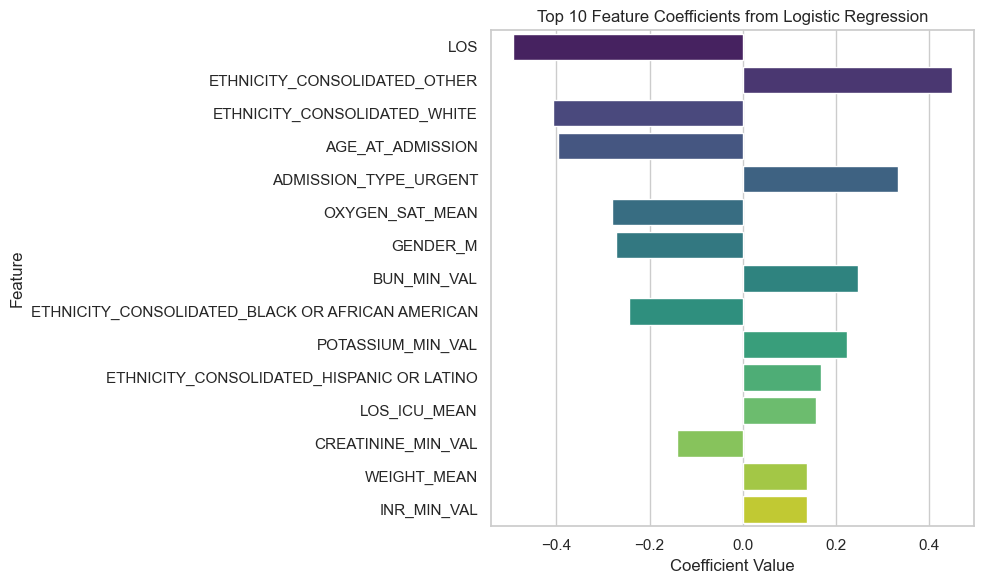

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.64      0.29      0.40       255
           1       0.77      0.93      0.85       656

    accuracy                           0.76       911
   macro avg       0.70      0.61      0.62       911
weighted avg       0.73      0.76      0.72       911

ROC-AUC Score on Test Set: 0.7513


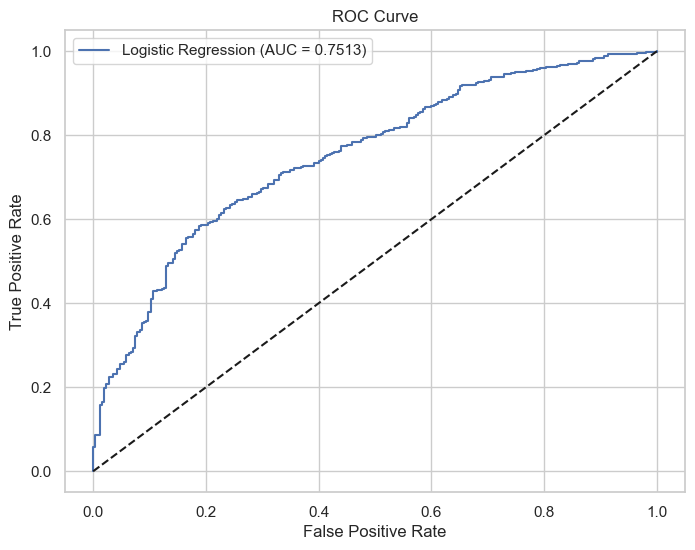

In [234]:
# Initialize the Logistic Regression model with increased iterations and random state for reproducibility
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Define K-Fold cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and compute accuracy scores
cv_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=kf, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Average Cross-Validation Accuracy: {np.mean(cv_scores):.4f}')

# Perform cross-validated predictions
y_pred = cross_val_predict(log_reg, X_train_scaled, y_train, cv=kf)

# Compute confusion matrix
cm = confusion_matrix(y_train, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Did Not Survive', 'Survived'],
            yticklabels=['Did Not Survive', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ----------------------------------------
# Fit the Logistic Regression model on the entire training data
# ----------------------------------------
log_reg.fit(X_train_scaled, y_train)

# Plot top most impactful features from Logistic Regression

# Extract coefficients from the fitted model
coefficients = log_reg.coef_[0]

# Create a DataFrame for coefficients
coefficients_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
})

# Calculate the absolute value of coefficients for sorting
coefficients_df['Abs_Coefficient'] = coefficients_df['Coefficient'].abs()

# Sort the DataFrame by absolute coefficient values in descending order
coefficients_df = coefficients_df.sort_values(by='Abs_Coefficient', ascending=False)

save_dataframe(coefficients_df, 'LogisticRegressionCoefficients.csv', base_directory)

# Select the top 10 features
top_features_df = coefficients_df.head(15)

# Plot the top 10 feature coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=top_features_df, palette='viridis')
plt.title('Top 10 Feature Coefficients from Logistic Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# ----------------------------------------
# (Optional) Evaluate the model on the test set
# ----------------------------------------

# Predict on the test set
y_test_pred = log_reg.predict(X_test_scaled)
y_test_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

# Compute and display classification report
print("Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

# Compute and display ROC-AUC score
roc_auc = roc_auc_score(y_test, y_test_prob)
print(f'ROC-AUC Score on Test Set: {roc_auc:.4f}')


fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Random Forest


Cross-Validation Accuracy Scores: [0.75857339 0.74759945 0.75994513 0.75857339 0.72115385]
Average Cross-Validation Accuracy: 0.75


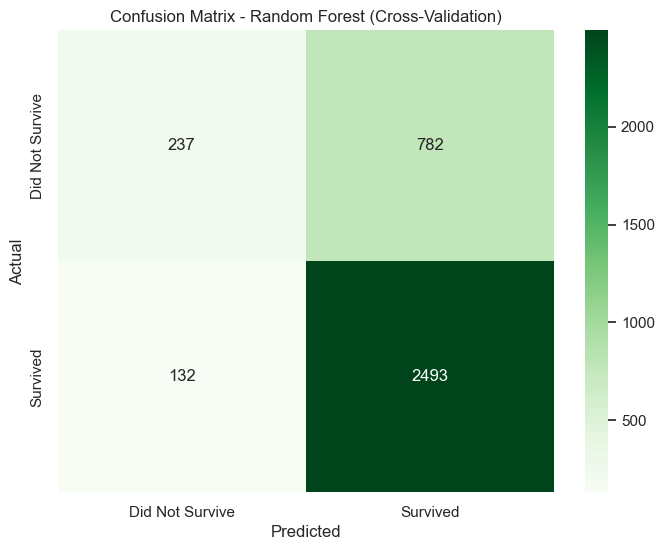

RandomForestImportance.csv saved successfully at: /Users/josh/Desktop/Macbook Working Files/Git Repos/650-DRAGON-SLAYERS/FILES/Data/RandomForestImportance.csv


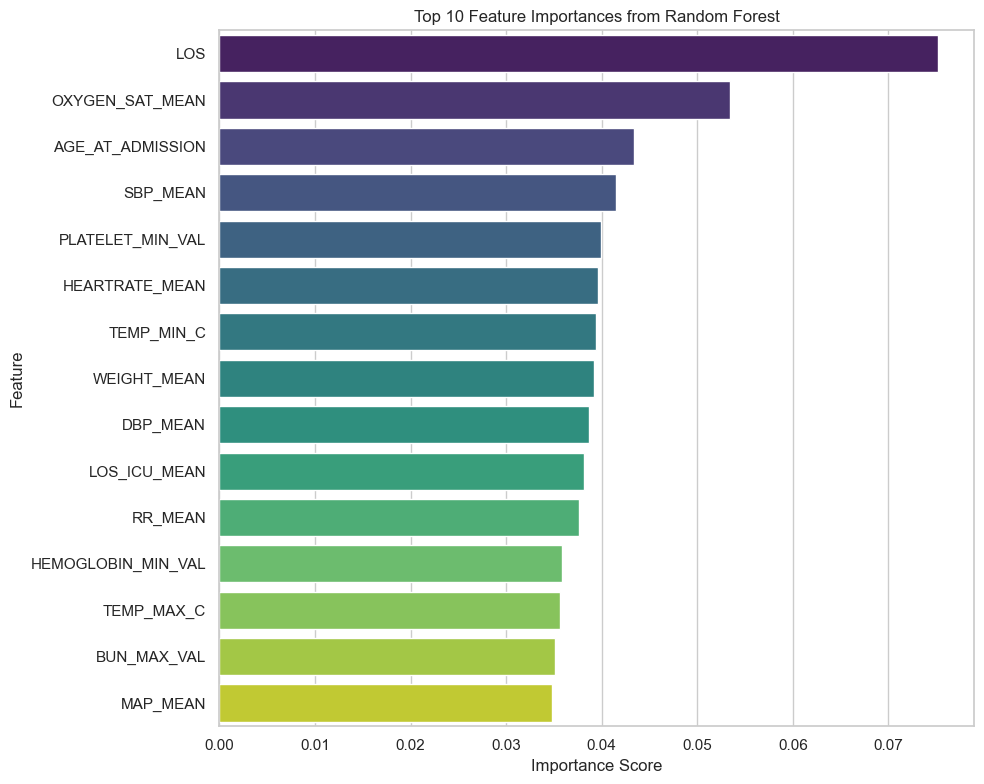

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.72      0.28      0.40       255
           1       0.77      0.96      0.86       656

    accuracy                           0.77       911
   macro avg       0.75      0.62      0.63       911
weighted avg       0.76      0.77      0.73       911

ROC-AUC Score on Test Set: 0.7561


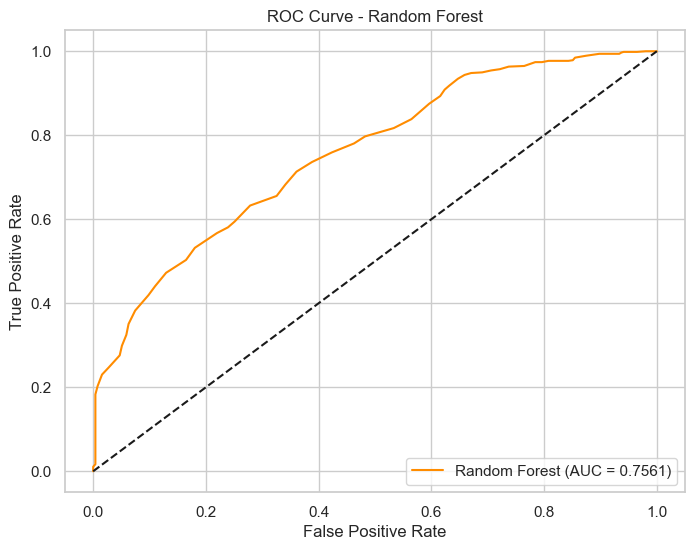

In [236]:
# Initialize the Random Forest Classifier with reproducibility
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Define K-Fold cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation scoring
cv_scores = cross_val_score(rf, X_train_scaled, y_train, cv=kf, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Average Cross-Validation Accuracy: {cv_scores.mean():.2f}')

# Perform cross-validated predictions
y_pred_cv = cross_val_predict(rf, X_train_scaled, y_train, cv=kf)

# Compute confusion matrix
cm = confusion_matrix(y_train, y_pred_cv)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Did Not Survive', 'Survived'],
            yticklabels=['Did Not Survive', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest (Cross-Validation)')
plt.show()

# Fit the Random Forest model on the entire training data
rf.fit(X_train_scaled, y_train)

# Extract feature importances
feature_importances = rf.feature_importances_
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort features by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

save_dataframe(feature_importances_df, 'RandomForestImportance.csv', base_directory)

# Select top 10 features
top_features_df = feature_importances_df.head(15)

# Plot top 10 feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_features_df, palette='viridis')
plt.title('Top 10 Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# -----------------------------
# Model Evaluation on Test Set
# -----------------------------

# Predict on the test set
y_test_pred = rf.predict(X_test_scaled)
y_test_prob = rf.predict_proba(X_test_scaled)[:, 1]

# Compute and display classification report
print("Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

# Compute and display ROC-AUC score
roc_auc = roc_auc_score(y_test, y_test_prob)
print(f'ROC-AUC Score on Test Set: {roc_auc:.4f}')

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.4f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()

## XGBoost

### Initial XGBoost Model Iteration

In [219]:
# Initialize the XGBoost Classifier
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_estimators=100  # Set the number of trees explicitly
)

# Train the model without early stopping
xgb_clf.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_test_scaled, y_test)],
    verbose=True
)

# Make predictions
y_pred_proba = xgb_clf.predict_proba(X_test_scaled)[:, 1]
y_pred = xgb_clf.predict(X_test_scaled)

# Evaluate the model
print("=== Model Evaluation ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}\n")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

[0]	validation_0-logloss:0.55344
[1]	validation_0-logloss:0.53118
[2]	validation_0-logloss:0.51855
[3]	validation_0-logloss:0.51490
[4]	validation_0-logloss:0.51177
[5]	validation_0-logloss:0.50622
[6]	validation_0-logloss:0.50257
[7]	validation_0-logloss:0.50056
[8]	validation_0-logloss:0.50057
[9]	validation_0-logloss:0.50000
[10]	validation_0-logloss:0.49875
[11]	validation_0-logloss:0.49810
[12]	validation_0-logloss:0.50331
[13]	validation_0-logloss:0.50371
[14]	validation_0-logloss:0.50479
[15]	validation_0-logloss:0.51037
[16]	validation_0-logloss:0.51000
[17]	validation_0-logloss:0.51167
[18]	validation_0-logloss:0.51573
[19]	validation_0-logloss:0.51723
[20]	validation_0-logloss:0.51787
[21]	validation_0-logloss:0.51878
[22]	validation_0-logloss:0.51839
[23]	validation_0-logloss:0.51946
[24]	validation_0-logloss:0.52046
[25]	validation_0-logloss:0.52026
[26]	validation_0-logloss:0.52414
[27]	validation_0-logloss:0.52649
[28]	validation_0-logloss:0.52760
[29]	validation_0-loglos

### Model Tuning with GridSearch

In [220]:
# Hyperparameter Tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)

best_xgb = grid_search.best_estimator_

# Predictions with the best model
y_pred_best = best_xgb.predict(X_test_scaled)
y_pred_proba_best = best_xgb.predict_proba(X_test_scaled)[:, 1]

# Evaluation of the best model
print("\n=== Best Model Evaluation ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_best):.4f}")

Fitting 5 folds for each of 1500 candidates, totalling 7500 fits
Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}

=== Best Model Evaluation ===
Accuracy: 0.7717
ROC AUC Score: 0.7832


### XGBoost Model Performance and Evaluation Visuals

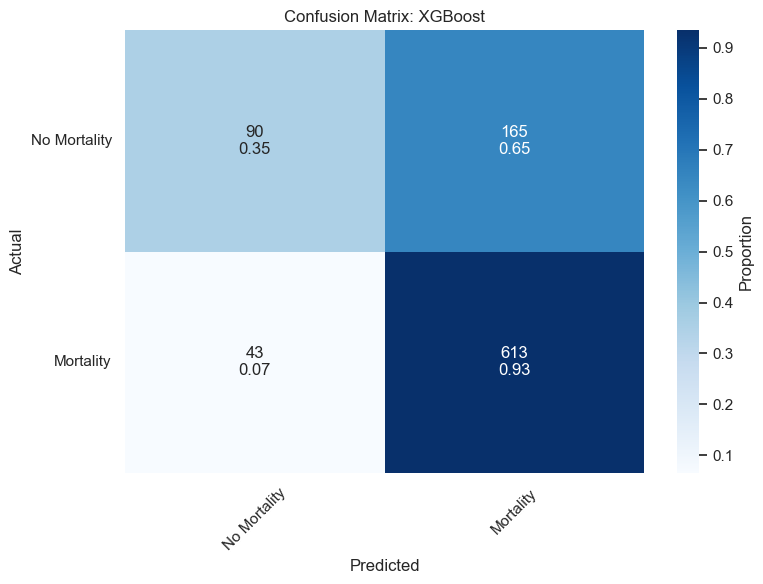

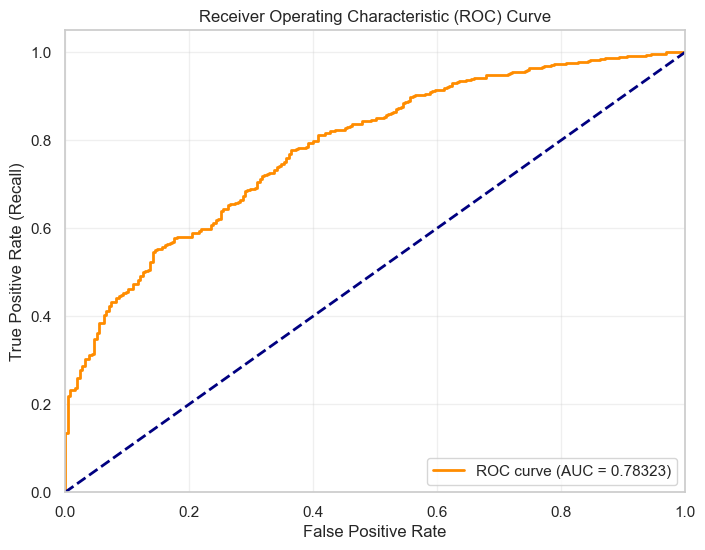

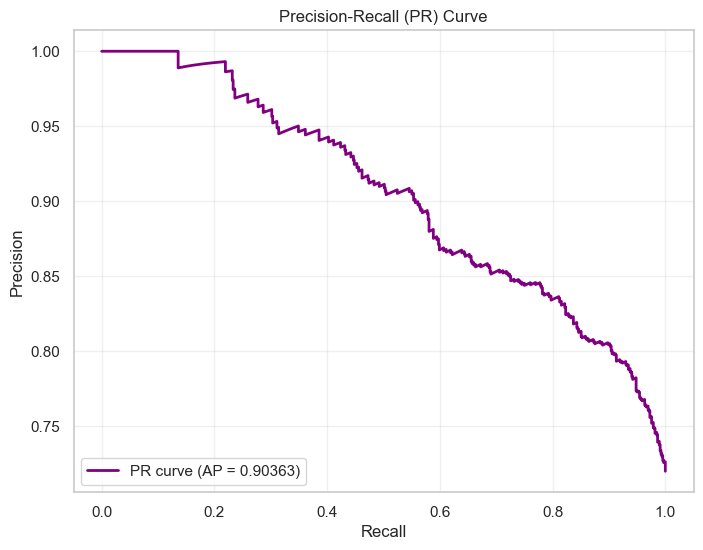

XGBoostImportance.csv saved successfully at: /Users/josh/Desktop/Macbook Working Files/Git Repos/650-DRAGON-SLAYERS/FILES/Data/XGBoostImportance.csv


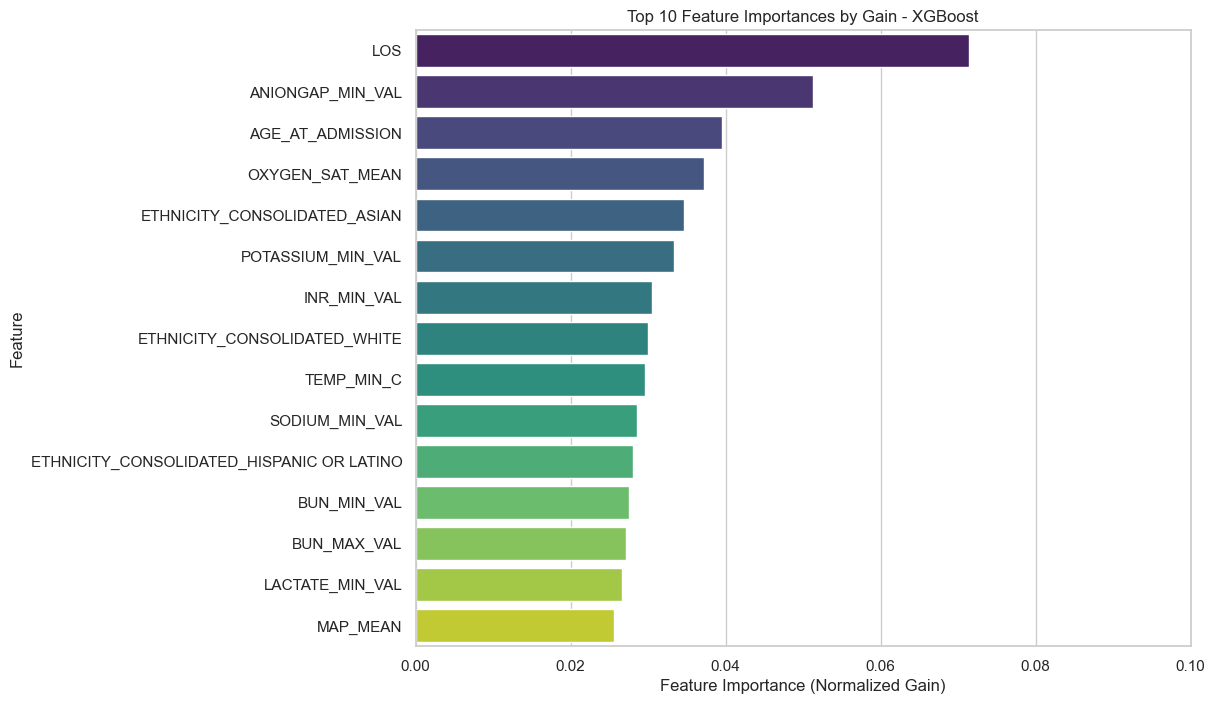

,Feature,Gain,Normalized Gain
0,LOS,11.830380,0.071376
1,ANIONGAP_MIN_VAL,8.511285,0.051351
2,AGE_AT_ADMISSION,6.546314,0.039496
3,OXYGEN_SAT_MEAN,6.159743,0.037163
4,ETHNICITY_CONSOLIDATED_ASIAN,5.747664,0.034677
5,POTASSIUM_MIN_VAL,5.527178,0.033347
6,INR_MIN_VAL,5.065012,0.030559
7,ETHNICITY_CONSOLIDATED_WHITE,4.973119,0.030004
8,TEMP_MIN_C,4.901346,0.029571
9,SODIUM_MIN_VAL,4.747461,0.028643


In [238]:
# 1. Compute the confusion matrices
cm_counts = confusion_matrix(y_test, y_pred_best)
cm_normalized = confusion_matrix(y_test, y_pred_best, normalize='true')

# Define class labels
class_labels = ['No Mortality', 'Mortality']

# Create annotations combining counts and proportions
annotations = np.empty_like(cm_counts).astype(str)

for i in range(cm_counts.shape[0]):
    for j in range(cm_counts.shape[1]):
        count = cm_counts[i, j]
        proportion = cm_normalized[i, j]
        annotations[i, j] = f"{count}\n{proportion:.2f}"

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_normalized,
    annot=annotations,
    fmt="",
    cmap='Blues',
    xticklabels=class_labels,
    yticklabels=class_labels,
    cbar_kws={'label': 'Proportion'}
)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix: XGBoost')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_best)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))

# Plot the ROC curve
plt.plot(
    fpr,
    tpr,
    color='darkorange',
    lw=2,
    label=f'ROC curve (AUC = {roc_auc:.5f})'
)

# Plot the diagonal line for random guessing
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')


# Set plot limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Labeling
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Add legend
plt.legend(loc="lower right")

# Add grid for better readability
plt.grid(alpha=0.3)

# Display the plot
plt.show()

# 3. Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba_best)
average_precision = average_precision_score(y_test, y_pred_proba_best)

plt.figure(figsize=(8, 6))
plt.plot(
    recall,
    precision,
    color='purple',
    lw=2,
    label=f'PR curve (AP = {average_precision:.5f})'
)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curve')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.show()

# 4. Feature Importance Plot
# Extract feature importance scores using 'gain'
importances = best_xgb.get_booster().get_score(importance_type='gain')

# Convert to DataFrame for better manipulation
importance_df = pd.DataFrame({
    'Feature': list(importances.keys()),
    'Gain': list(importances.values())
})

# Sort the DataFrame by 'Gain' in descending order
importance_df = importance_df.sort_values(by='Gain', ascending=False).reset_index(drop=True)

# Normalize the 'Gain' to a 0.00 - 1.00 scale
total_gain = importance_df['Gain'].sum()
importance_df['Normalized Gain'] = importance_df['Gain'] / total_gain
importance_df['Normalized Gain'] = importance_df['Normalized Gain'].round(8)

save_dataframe(importance_df, 'XGBoostImportance.csv', base_directory)

# Select top 10 features
top_features = importance_df.head(15)

# Plotting the Feature Importance
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Normalized Gain',
    y='Feature',
    data=top_features,
    palette='viridis'
)
plt.xlabel('Feature Importance (Normalized Gain)')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances by Gain - XGBoost')
plt.xlim(0, 0.1)
plt.show()

importance_df

## Comparison

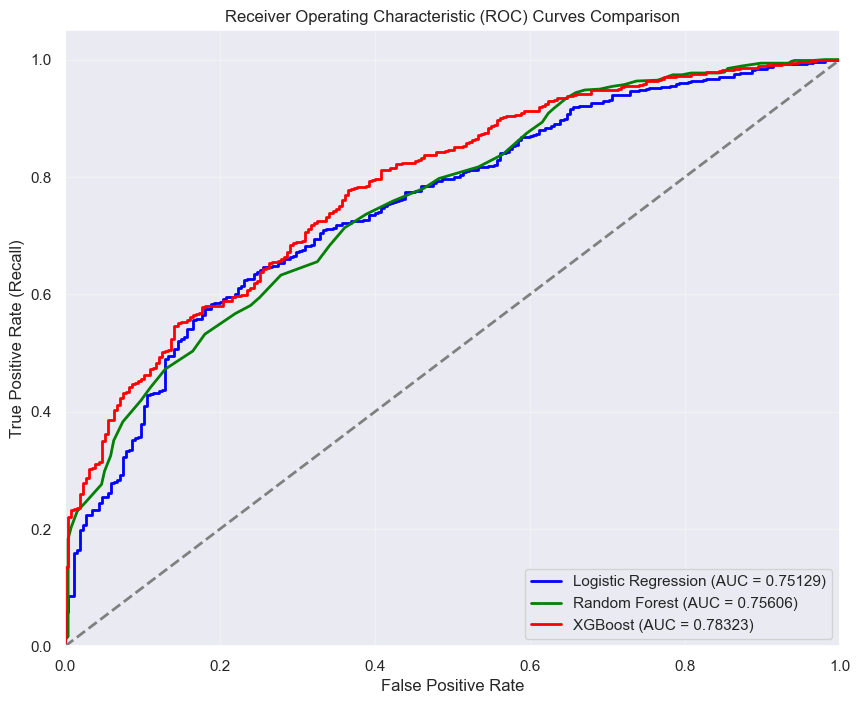

In [223]:
y_pred_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

# For Random Forest
y_pred_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]

# For XGBoost
y_pred_proba_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve and AUC for each model
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot all ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2,
         label=f'Logistic Regression (AUC = {roc_auc_lr:.5f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2,
         label=f'Random Forest (AUC = {roc_auc_rf:.5f})')
plt.plot(fpr_xgb, tpr_xgb, color='red', lw=2,
         label=f'XGBoost (AUC = {roc_auc_xgb:.5f})')

# Plot diagonal line for random guessing
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curves Comparison')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

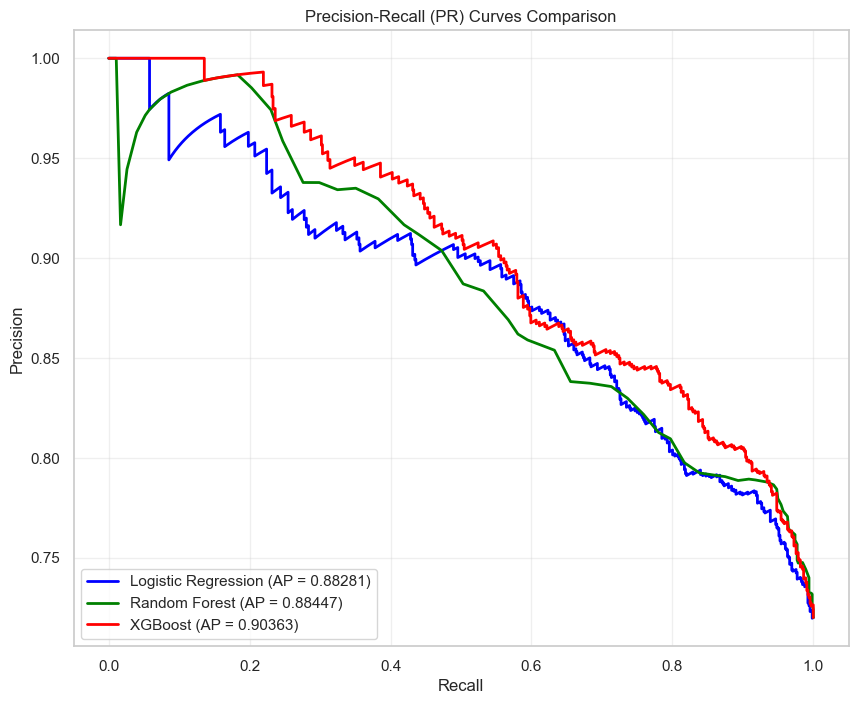

In [228]:
# Compute Precision-Recall curves and average precision
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_proba_lr)
average_precision_lr = average_precision_score(y_test, y_pred_proba_lr)

precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_rf)
average_precision_rf = average_precision_score(y_test, y_pred_proba_rf)

precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_proba_xgb)
average_precision_xgb = average_precision_score(y_test, y_pred_proba_xgb)

# Plot Precision-Recall curves
plt.figure(figsize=(10, 8))
plt.plot(recall_lr, precision_lr, color='blue', lw=2,
         label=f'Logistic Regression (AP = {average_precision_lr:.5f})')
plt.plot(recall_rf, precision_rf, color='green', lw=2,
         label=f'Random Forest (AP = {average_precision_rf:.5f})')
plt.plot(recall_xgb, precision_xgb, color='red', lw=2,
         label=f'XGBoost (AP = {average_precision_xgb:.5f})')

# Customize the plot
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curves Comparison')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.show()

In [229]:
# For Logistic Regression
y_pred_lr = log_reg.predict(X_test_scaled)
y_pred_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

# For Random Forest
y_pred_rf = rf.predict(X_test_scaled)
y_pred_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]

# For XGBoost
y_pred_xgb = best_xgb.predict(X_test_scaled)
y_pred_proba_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]
# Initialize a dictionary to store metrics
metrics = {
    'Model': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

# Define a list of models and their predictions
model_predictions = {
    'Logistic Regression': y_pred_lr,
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb
}

# Calculate metrics for each model
for model_name, y_pred in model_predictions.items():
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    metrics['Model'].append(model_name)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    metrics['F1-Score'].append(f1)

# Create a DataFrame from the metrics dictionary
metrics_df = pd.DataFrame(metrics)

# Display the comparison table
metrics_df

,Model,Precision,Recall,F1-Score
0,Logistic Regression,0.773014,0.934451,0.846101
1,Random Forest,0.773399,0.957317,0.855586
2,XGBoost,0.787918,0.934451,0.854951


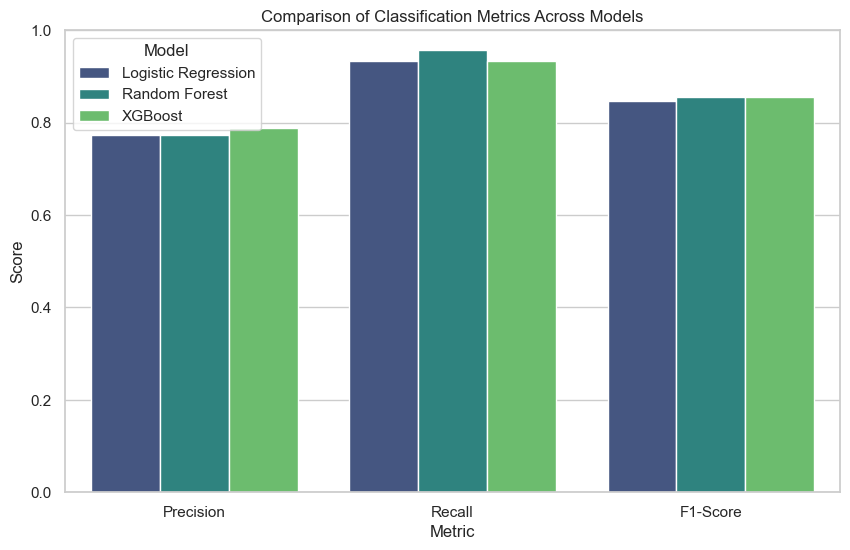

In [230]:


# Set the figure size
plt.figure(figsize=(10, 6))

# Melt the DataFrame for seaborn compatibility
metrics_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Create a bar plot
sns.barplot(x='Metric', y='Score', hue='Model', data=metrics_melted, palette='viridis')

# Add titles and labels
plt.title('Comparison of Classification Metrics Across Models')
plt.ylim(0, 1)  # Since metrics range from 0 to 1
plt.legend(title='Model')

# Display the plot
plt.show()
